# Practical session 4 - K-nearest neighbours (K-NN) classification with numpy, scikit-learn, cython and numba

Students (pair):
- [BLANQUART Ekhi](https://github.com/azagal952)
- [DENISSELLE Alexis](https://github.com/AlexisDns23)

**Useful references for this lab**:

[1] scikit-learn: [documentation](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification)

[2] `numba`: [documentation](http://numba.pydata.org/) 

[3] cython: [a very useful tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), and [another one](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)



## <a name="content">Contents</a>
- [Exercise 1: KNN classification with numpy and sklearn](#ex1)
- [Exercise 2: Code acceleration with cython](#ex2)
- [Exercise 3: Code acceleration with numba](#ex3)
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## <a name="ex1">Exercise 1: K-Nearest Neighbours (K-NN) classification with numpy and scikit-learn</a> [(&#8593;)](#content)

This session is a first introduction to classification using the most intuitive non parametric method: the $K$-nearest neighbours. The principle is [the following](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification). A set of labelled observations is given as a learning set. A classification taks then consists in assigning a label to any new observation. In particular, the K-NN approach consists in assigning to the observation the most frequent label among its $K$ nearest neighbours taken in the training set.

### A. Validation on synthetic data

Load the training and test datasets `data/synth_train.txt` and `data/synth_test.txt`. Targets belong to the set $\{1,2\}$ and entries belong to $\mathbb{R}^2$. The file `data/synth_train.txt` contain 100 training data samples, and `data/synth_test.txt` contains 200 test samples, where:

- the 1st column contains the label of the class the sample;
- columns 2 & 3 contain the coordinates of each sample (in $\mathbb{R}^2$).

Useful commands can be found below.

```python
# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]
```

```python
# load the test set
test = np.loadtxt('/datasynth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]
```

1\. Display the training set and distinguish the two classes. 

> Hint: useful functions include `matplotlib.pyplot.scatter` or `matplotlib.pyplot.plot`.

**Answer:**

In [45]:
# load the training set
train = np.loadtxt('data/synth_train.txt')
class_train = train[:, 0].astype(int) # labels of the train set
class_train_1 = train[train[:, 0] == 1]
class_train_2 = train[train[:, 0] == 2]
x_train = train[:, 1:]

# load the test set
test = np.loadtxt('data/synth_test.txt')
class_test = test[:, 0].astype(int)
class_test_1 = test[test[:, 0] == 1]
class_test_2 = test[test[:, 0] == 2]
x_test = test[:, 1:]

N_train = train.shape[0]
N_test = test.shape[0]

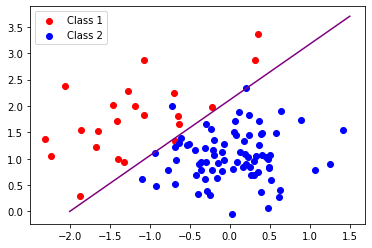

In [46]:
plt.scatter(class_train_1[:, 1], class_train_1[:, 2], color='red',  label='Class 1')
plt.scatter(class_train_2[:, 1], class_train_2[:, 2], color='blue', label='Class 2')
x=np.array([[-2,0],[1.5,3.7]])
plt.plot(x[:,0],x[:,1], '-', color='purple')
plt.legend(loc = 'best')
plt.show()

2\. Implement the K-nearest neighbours algorithm for classification.

> Hint: 
> - useful functions include `numpy.linalg.norm`, `numpy.argsort`, `numpy.bincount`;
> - implement the algorithm as a function rather than an object. This will drastically simplify the acceleration step using Cython.
> - for an optimized partial sorting procedure, you may have a look at the [`bottleneck.argpartition` function](https://bottleneck.readthedocs.io/en/latest/reference.html#bottleneck.argpartition).

**Answer:**

In [53]:
def KNN_algorithm(x_train, class_train, x_test, k):
    """Perform the K-nearest neighbours algorithm for classification

    Args:
        x_train (np.ndarray): matrix of coordinates of the train set
        class_train (np.ndarray): labels of points in train set
        x_test (np.ndarray): matrix of coordinates of the test set
        k (int): Number of nearest neighbours to consider

    Returns:
        np.ndarray: predicted labels for x_test
    """
    class_test_pred = np.zeros(x_test.shape[0], dtype=class_train.dtype)

    for i, test_point in enumerate(x_test):
        ## For each point of the test set, we compute the distance between each point of x_train and this test point.
        distances = np.linalg.norm(x_train - test_point, axis=1)

        ## We select indexes of the k points of x_train for which the distance with the point of x_test is minimal
        nearest_neighbor_ids = np.argsort(distances)[:k]

        nearest_neighbor_labels = class_train[nearest_neighbor_ids]
        class_test_pred[i] = np.bincount(nearest_neighbor_labels).argmax()

    return class_test_pred

3\. Compute the error rate on the training set and the test set for $K \in \{1,2, \dotsc, 20\}$. Display the classification result (see 1.) for the configuration with the lowest error rate.

**Answer:**

Error rate for 1-NN algorithm is:0.065
Error rate for 2-NN algorithm is:0.06
Error rate for 3-NN algorithm is:0.045
Error rate for 4-NN algorithm is:0.05
Error rate for 5-NN algorithm is:0.06
Error rate for 6-NN algorithm is:0.055
Error rate for 7-NN algorithm is:0.07
Error rate for 8-NN algorithm is:0.07
Error rate for 9-NN algorithm is:0.075
Error rate for 10-NN algorithm is:0.075
Error rate for 11-NN algorithm is:0.09
Error rate for 12-NN algorithm is:0.075
Error rate for 13-NN algorithm is:0.08
Error rate for 14-NN algorithm is:0.075
Error rate for 15-NN algorithm is:0.075
Error rate for 16-NN algorithm is:0.075
Error rate for 17-NN algorithm is:0.08
Error rate for 18-NN algorithm is:0.08
Error rate for 19-NN algorithm is:0.08
Error rate for 20-NN algorithm is:0.08


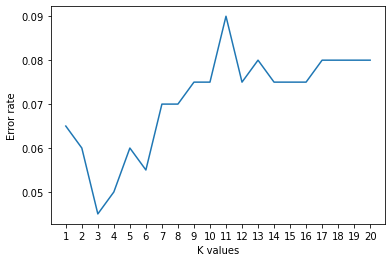

In [60]:
error_rate = np.zeros(20)
for k in range (1,21):
    class_test_pred=KNN_algorithm(x_train, class_train, x_test, k)
    sum=np.sum(class_test_pred!=class_test)
    error_rate[k - 1] = sum/N_test
    print(f"Error rate for {k}-NN algorithm is:{error_rate[k - 1]}")
plt.plot(np.arange(1,21),error_rate)
plt.xticks(range(1,21))
plt.xlabel('K values')
plt.ylabel("Error rate")
plt.show()

In [62]:
class_test_pred=KNN_algorithm(x_train, class_train, x_test, 3)

false_positive = class_test_1[class_test_pred[:] == 2]
false_negative = class_test_2[class_test_pred == 1]
true_positive = class_test_2[class_test_pred == 2]
true_negative = class_test_1[class_test_pred == 1]


plt.scatter(class_train_1[:, 1], class_train_1[:, 2], color='red',  label='Class 1')
plt.scatter(class_train_2[:, 1], class_train_2[:, 2], color='blue', label='Class 2')
x=np.array([[-2,0],[1.5,3.7]])
plt.plot(x[:,0],x[:,1], '-', color='purple')
plt.legend(loc = 'best')
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 62 but corresponding boolean dimension is 200

4\. Comment on your results. Which value of $K$ seems optimal ?


**Answer:**

The error rate is minimal for K=3

5\. Compare the results of you implementation with those of [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier). Compare the runtime of these two versions using the [`timeit`](https://docs.python.org/3/library/timeit.html) module (see session 1).

**Answer:**

In [8]:
# your code

### B. Application to a real dataset (Breast cancer Wisconsin).

6\. Apply the K-NN classifier to the real dataset `data/wdbc12.data.txt.` Further details about the data are provided in `data/wdbc12.names.txt`.

> Hint: you can use the function [`train_test_split` from `sklearn.model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into a training and a test set.

**Answer:**

In [9]:
# your code

## <a name="ex2">Exercise 2: Code acceleration with cython</a> [(&#8593;)](#content)

Cython allows C code to be easily interfaced with Python. It can be useful to make your code faster for a small coding effort, in particular when using loops. A general approach to optimize your code is outlined in the [Scipy lecture notes, Section 2.4](https://scipy-lectures.org/advanced/optimizing/index.html). Complementary reading about interfacing Python with C can be found in [Section 2.8](https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html).

1\. Read carefully the [cython tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html), which describes step by the step how the toy example reported below has been developed.

**Setup**: Compile the toy example provided in `example_cy/` by running, in the command line (anaconda prompt on windows)

```bash
cd example_cy && python setup.py build_ext --inplace
```

Note that the compilation process has been slightly automatised with the instructions reported in `example_cy/setup.py`. To test the module, run

In [10]:
!cd example_cy && python setup.py build_ext --inplace

Compiling helloworld.pyx because it changed.

error: Unable to find vcvarsall.bat



Compiling primes.pyx because it changed.
[1/2] Cythonizing helloworld.pyx
[2/2] Cythonizing primes.pyx
running build_ext
building 'example_cy.helloworld' extension


In [11]:
import example_cy.example_cy.helloworld as toy

toy.printhello()

ModuleNotFoundError: No module named 'example_cy.example_cy'

which should display
```python
Hello World
```

> Warning: 
> - do not forget to include an empty `__init__.py` file in the directory where your source code lives (`import` will fail if this is not the case).
> - in case you have any setup issue, take a look at the `notes.md` file.
> - if the C code and/or the executable do not seem to be regenerated by the build instructions, delete the C code and the executable first, and re-execute the compilation afterwards.
> - do not hesitate to restart the Python kernel if necessary when the Cython executable has been re-generated.

2\. Read the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), focussing on the paragraphs **Cython at a glance**, and **Your Cython environment** until **"More generic code"**. An example to compile a `.pyx` file depending on `numpy` is included in `example_np_cy/`.

> Remarks: 
> - the `annotate=True` flag in the `setup.py` allows an additional `.html` document to be generated (`<your_module_name>.html`), showing, for each line of the Cython code, the associated C instructions generated. Highlighted in yellow are the interactions with Python: the darker a region appears, the less efficient the generated C code is for this section. Work in priority on these! 
> - make sure all the previously generated files are deleted to allow the .html report to be generated;
> - if you are working on your own machine and don't have a C/C++ compiler installed, read the notes provided in `notes.md`;
> - use `cdef` for pure C functions (not exported to Python), `cpdef` should be favored for functions containing C instructions and later called from Python.

**Answer:**

In [ ]:
# your code

3\. Use Cython to implement a faster version of the numpy K-NN classifier implemented in [Exercise 1](#ex1). To do so, apply step-by-step the techniques introduced in the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial) (*i.e.*, compile and time your code after each step to report the evolution, keeping track of the different versions of the cython function).

> Hint: if you keep numpy arrays, make sure you use memory views (see numpy/cython tutorial) to access the elements within it. Be extremely careful with the type of the input arrays (you may need to recast the format of the input elements before entering the function. The `numpy.asarray` function can prove useful).

> **Detailed guidelines**: a few notes and *caveat* to help you re-writing your code in cython:
> - try to reduce the number of calls to numpy instructions as much as possible;
> - **you do not have to optimize everything**. For the KNN function above, most of the time is spent in computing euclidean distances: you can thus focus on optimizing tihs operations by explicitly writing a for loop, which will ensure a minimal interaction with numpy when generating the associated C code at compilation. Calls to other numpy functions can be kept as-is;
> - if you need to create an array within the cython function, used np.zeros (**do NOT use python lists**), and use a memory view to access its content;
> - specify the type for all variables and numpy arrays. Pay attention to the type of the input arrays passed to the Cython function;
> - whenever an array is returned, use memory views and index(es) to efficiently access its content;
> - some numpy operators (e.g., broadcasting mechanism) do not work with memory views. In this case, you can directly write for loop(s) to encode the operation of interest (the loops will be optimized out at compile time);
> - only use at the final development stage the following cython optimization (not before, as they can crash the program without any help):
>
>```python
>@cython.boundscheck(False)
>@cython.wraparound(False)
>```

**Answer:**

In [ ]:
# your code

4\. Compare the runtime of the two algorithms (using `timeit.timeit`), and conclude about the interest of using cython in this case.

**Answer:**

In [ ]:
# your code

## <a name="ex3">Exercise 3: Code acceleration with numba</a> [(&#8593;)](#content)

`numba` is a just-in-time (JIT) compiler which translates Python codes into efficient machine code at runtime. A significant acceleration can be obtained by adding a few simple decorators to a standard Python function, up to a few restrictions detailed [here](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html).

If you have written most of the KNN classifier of exercise 1 with numpy, there is little to no chance that you will get an acceleration with numba (justifying the use of cython in this case). An interesting acceleration factor can however be obtained for the computation of the total variation investigated in session 2.

1\. Take a look at the [numba 5 min tour](http://numba.pydata.org/numba-doc/latest/user/5minguide.html), and accelerate the total variation code from session 2 with the `@jit` decorator. You may have to rewrite small portions of your code to get the expected acceleration (see [performance tips](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html)).

**Answer:**

In [ ]:
# your code

2\. Compare the runtime of the your numpy implementation and the `numba`-accelerated version (using `timeit.timeit`). 
> **Warning**: first run the numba version once to trigger the compilation, and then time it as usual. This is needed to avoid including the JIT compilation step in the runtime.

**Answer:**

In [ ]:
# your code